In [151]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata, load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.gray()
%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original')
X = (mnist['data'] / 255.0).astype(np.float32)
y = mnist['target']

# Principal component analysis
Principal component analysis is motivated by the observation that in real life, data is correlated. If we recieve many data points, which have a covariance that is drastically different from a diagonal matrix, that means that much of the variation in the data can be accounted for in directions other than the coordinate unit vectors. In particular, imagine our data is of the form $X\in \mathbb{R}^{N\times D}$, i.e. we have $N$ data points each of which is $D$-dimensional. Here, we assume that each column of $X$ is zero-centered, and if it isn't, we can subtract the mean and proceed.

If we say the optimal vector (i.e. first principal component) is $w$ (with norm 1), then for each row $x_j$ of $X$, we want to maximize $x_j \cdot w$. This intuitively makes sense because that quantity is maximized for $x_j = a_j w$, the case where $w$ accounts for all of the variation in $x_j$, while in the case that they are perpendicular, meaning that $w$ does not help to explain $x_j$ at all, the magnitude is minimized. We can then combine this objective over each datapoint into $\lVert Xw \rVert$. This means that we wish to maximize $\lVert Xw \rVert$ over all vectors $w$ with $\lVert w \rVert = 1$. Note that the maximum is the 2-norm of $X$, as it will be the direction in which a vector can be "streteched" the most by $X$. Knowing that this is equal to the 2-norm of $X$, we can also say that the argmax is an eigenvector of $X^T X$, the covariance. Now that we have explained this portion of $X$, we remove if from the matrix, and continue. If we project $X$ onto $w$, we will get the "amount" of $w$ needed to maximally explain the variance in that direction in $X$. This means that if we take $X w w^T$, we will get our best estimate for the reconstruction of $X$. We can then obtain $X' = X-X w w^T$, which is the new matrix with all variation in the direction of $w$ removed. We can repeat this procedure on $X'$ to find the second eigenvector, and so on.

An alternative view of this is attempting to find some projection function $T: \mathbb{R}^D\to \mathbb{R}^M$ that minimizes the error $X - T^T(T(X))$. In this case, $M$ would be the number of principal components to consider. If we have a full rank orthonormal matrix $T$ here, $T^T(T(X))=X$, but when it is not, then $T^T T$ is only an approximation to the identity. This view is a nice way to look at PCA because we can think of our principal components as mapping $X$ to a subspace that preserves the most information about it. Of course, this does not account for nonlinear variation, but in terms of linear variation, this problem formulation is indeed ideal. This idea can be extended to nonlinear transformations, so we can try to find $f^T(f(X))$ that is nearest $X$. Although this loses the nice property of a basis representation of $X$, this still accomplishes the goal of embedding $X$ into a low dimensional feature space without losing much information.

## Experiments
In the experiments, I use the MNIST datset. It consists of 70000 handwritten digits that have been hand-labeled. First, we can take the principal components of this to transform $X$ to a lower-dimensional space. Then, if we wish to measure the performance of the PCA, we project this low dimensional representation back onto $X$, and measure how much error there is in the reconstruciton. Another way we can measure the performance of the PCA is by seeing how much variance is explained by each step principal component, or, in other words the 2-norm of the matrix $X'$. Note that in structured data, the primary components are expected to explain the majority of variance, while in random data, the explained variance will decrease linearly, as the variance is gradually explained.

We can also look at hand-picked examples to see how the reconstructions appear, as is done below. This might not be ideal, however, because it is hard to tell what the "best" exmaple of each number is. Instead, what we can do is, after projecting all of $X$ into the principal component space, run a clustering algorithm to try to determine what some centers of the data are. We don't necessarily expect this to a perfect example of all ten digits, but it can give a better sense of how points are grouped together in the lower-dimensional space. I use k-means clustering here, to try to find such centers. Interestingly, they represent a pretty wide variety of numbers. When projecting 10 dimensions, the separation of some different digits might not yet be optimal, which would explain why this occurs, but we do see better examples of number on the remaining digits. 

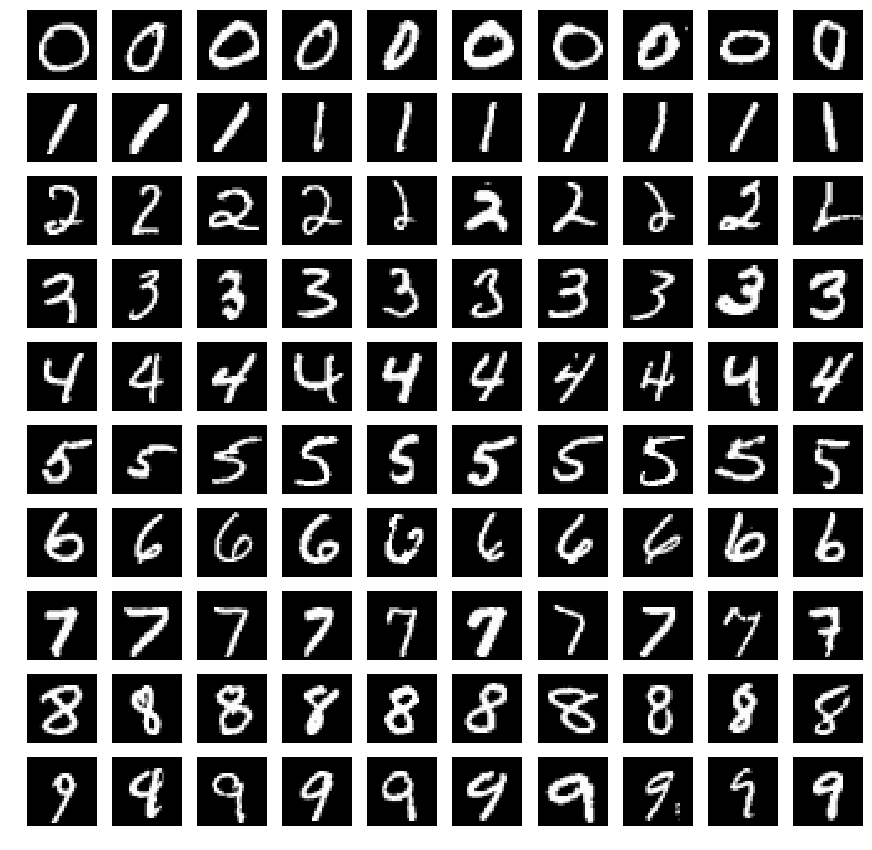

In [24]:
plt.figure(figsize=(15, 15))
for i in range(10):
    m = y==i
    xx = X[m]
    c = np.random.choice(len(xx), size=10, replace=False)
    xx = xx[c]
    for j in range(10):
        ax = plt.subplot(10, 10, i*10 + j+1)
        ax.imshow(xx[j].reshape(28, 28))
        ax.axis('off')

In [4]:
ex_ix = np.array([np.argmax(y==i) for i in range(10)])

In [5]:
Xp = X-X.mean(0)
cov = (Xp.T.dot(Xp)) / len(Xp)
rnk = np.linalg.matrix_rank(cov)
vecs, sigs, _ = np.linalg.svd(cov)
vecs = vecs[:, :rnk]
sigs = sigs[:rnk]

In [22]:
errs = []
xsub = Xp[np.random.choice(len(Xp), size=5000, replace=False)]
x_prev = np.zeros_like(xsub)
for i in range(1, min(vecs.shape[1], 100)): # Truncated because of time needed
    t = vecs[:, i, None]
    x_prev += xsub.dot(t).dot(t.T)
    errs.append(np.sqrt(np.mean((xsub - x_prev)**2)))

Text(0,0.5,'Reconstruction RMSE')

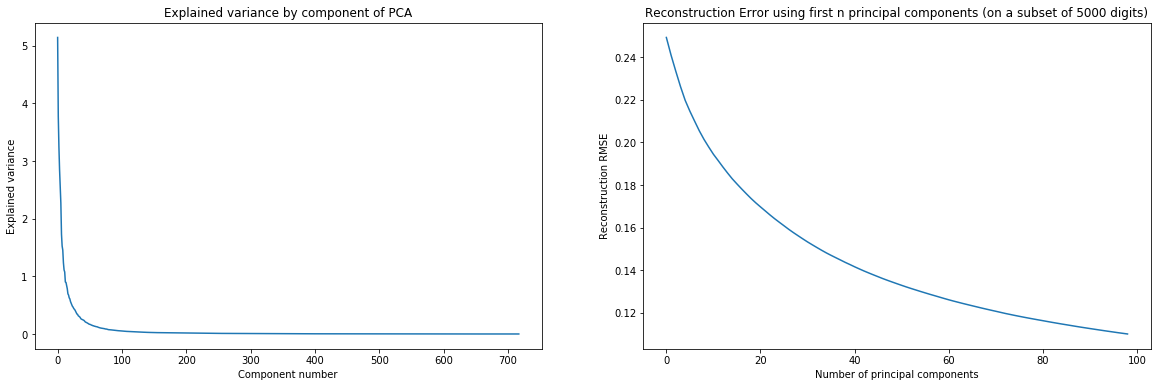

In [23]:
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(sigs)
ax.set_xlabel('Component number')
ax.set_ylabel('Explained variance')
ax.set_title('Explained variance by component of PCA')

ax = plt.subplot(1, 2, 2)
ax.plot(errs)
ax.set_title('Reconstruction Error using first n principal components (on a subset of 5000 digits)')
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Reconstruction RMSE')

## PCA of random data

Text(0.5,1,'Explained variance by component of PCA, random, uncorrelated data')

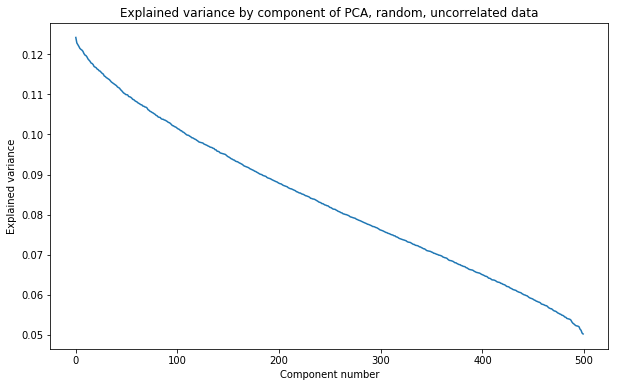

In [32]:
xrand = np.random.rand(10000, 500)
xrand -= xrand.mean(0)
rc = (xrand.T.dot(xrand)) / len(xrand)
rrnk = np.linalg.matrix_rank(rc)
rvecs, rsigs, _ = np.linalg.svd(rc)
rvecs = rvecs[:, :rrnk]
rsigs = rsigs[:rrnk]
plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(rsigs)
ax.set_xlabel('Component number')
ax.set_ylabel('Explained variance')
ax.set_title('Explained variance by component of PCA, random, uncorrelated points')

In [132]:
n_comps = 10
pcs = vecs[:, :n_comps]
x_transform = Xp.dot(pcs)
kms = KMeans(n_clusters=10,)
_ = kms.fit(x_transform)

## First 10 Principal components

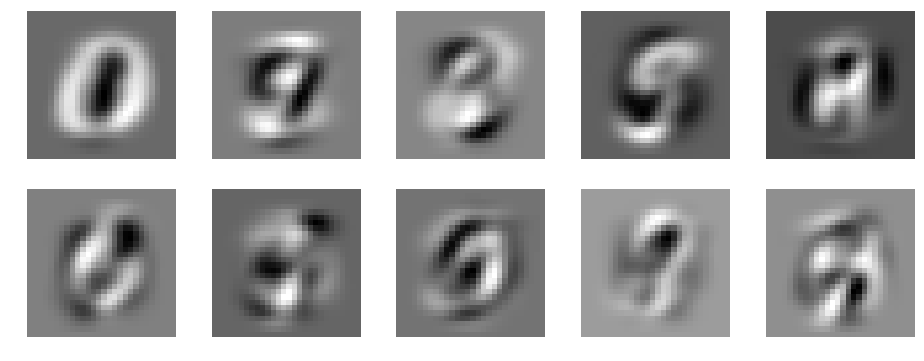

In [133]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow((vecs[:, i]).reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Sample Reconstructions of actual images (30 PC vectors)

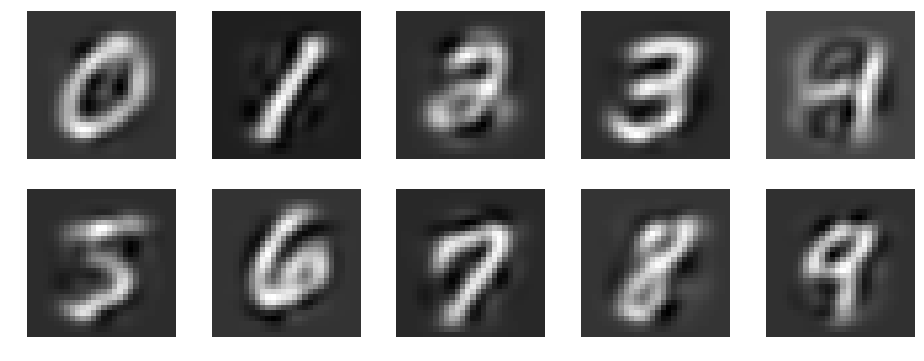

In [139]:
recon = Xp[ex_ix].dot(vecs[:, :30]).dot(vecs[:, :30].T) + X.mean(0)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Sample Reconstructions of noisy images ($\sigma=0.2$) (30 PC vectors)

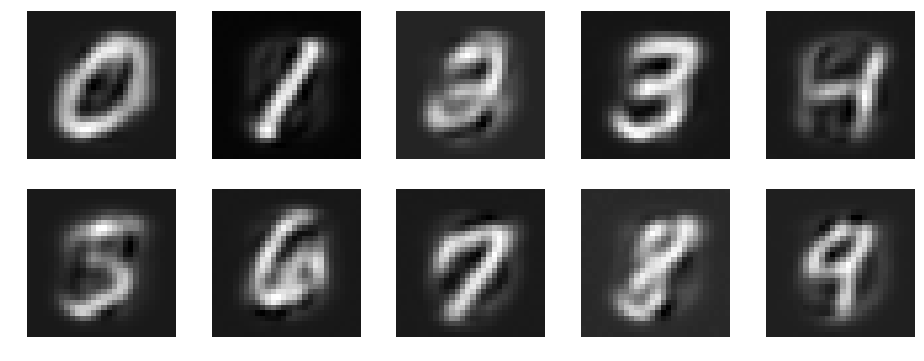

In [253]:
recon = (Xp[ex_ix]+np.random.rand(*Xp[ex_ix].shape) * 0.2).dot(vecs[:, :30]).dot(vecs[:, :30].T) + X.mean(0)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Example digits found from K-means in embedded space (10 PC vectors)

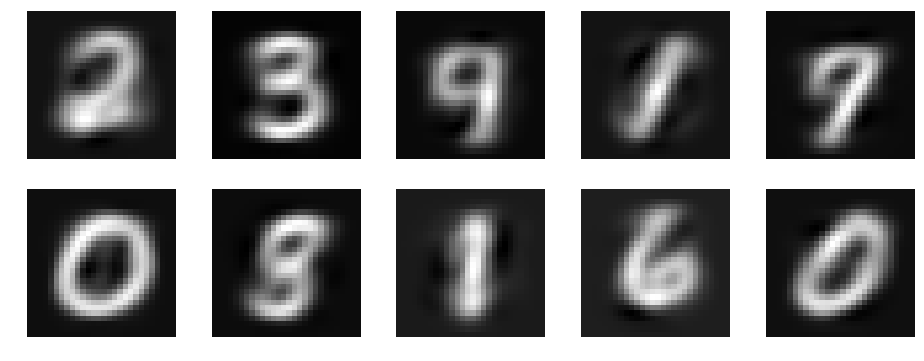

In [127]:
recon = kms.cluster_centers_.dot(pcs.T) + X.mean(0)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Elongating digits along principal components
If we decompose a digit into its principal components, we can try to scale the digit along these components for an digit with some characteristic more prominent. Note that it does not appear to significantly change the appearance of the digit, and only adds a "shadow" to the background. 

In [103]:
Xp = X-X.mean(0)
cov = (Xp.T.dot(Xp)) / len(Xp)
rnk = np.linalg.matrix_rank(cov)
vecs, sigs, _ = np.linalg.svd(cov)
vecs = vecs[:, :rnk]
sigs = sigs[:rnk]

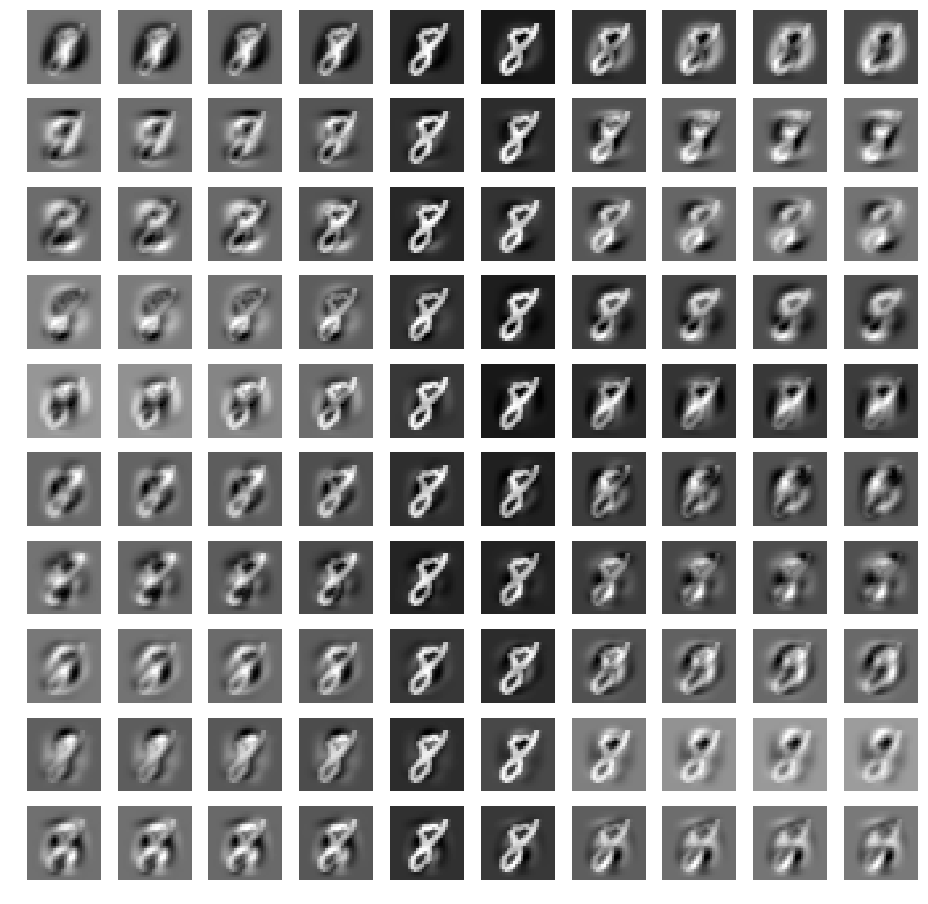

In [108]:
tr = X[ex_ix][8] # only use one example
plt.figure(figsize=(16, 16))
for i in range(10):
    diffs = np.linspace(-20, 20, 10)
    for j in range(10): #scale from -4x to 5x along principal component i
        ax = plt.subplot(10, 10, 10*i+j+1)
        scaled = tr + diffs[j]*vecs[:, i]
        ax.imshow(scaled.reshape(28, 28))
        ax.axis('off')

# Alternatives to PCA
PCA is very powerful because it has a simple interpretation and is linear, leading to nice theoretical properties. We can extend the idea of an information-preserving transform to low dimensions that is nonlinear, perhaps computed by a neural network. This concept is called an Autoencoder, and it allows for a better low-dimensional representation of the space (at the cost of interpretability). For this, I will use a small neural network (1 or 2 hidden layers), and an embedded space of dimension 10 to correspond to PCA. We can see that the k-means reconstruction from these embedded features is a bit crisper than what is found in PCA.

In [209]:
import tensorflow as tf
def next_batch(size):
    return X[np.random.choice(len(X), size=size, replace=False)]

## Laplacian prior
In PCA, we assume our data is normally distibuted, which leads to the minimization of reconstruction loss in the L2 norm, while if we assume a laplacian prior, we would be minimizing the L1 loss, which is perhaps a better objective in pictures. We can use an optimization tool (such as Tensorflow) to accomplish this minization with minimal effort.

We see results fairly similar to those of having an L2 reconstruction penalty, but perhaps a bit less clarity. This could be due to the fact that this was treated as an iterative procedure, trained by gradient descent, compared to the SVD. Overall, in this case, there seems to be no definite advantage to using an L1 reconstruction loss, but it is possible if the input data were noisier, it would be more useful.

In [247]:
emb_dim = 30
g = tf.Graph()
with g.as_default():
    x_in = tf.placeholder(tf.float32, (None, 784), 'input')
    emb_space_in = tf.placeholder(tf.float32, (None, emb_dim), 'latent_input')
    w1 = tf.Variable(tf.initializers.orthogonal()((784, emb_dim)))

    recon_loss = tf.reduce_mean(tf.abs(x_in @ w1 @ tf.transpose(w1) - x_in))
    train_op = tf.train.AdamOptimizer().minimize(recon_loss)
try: 
    while True: tf.get_default_session().close()
except: pass
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

In [248]:
train_errs = []
for it in range(3000):
    _, errrr = sess.run([train_op, recon_loss], feed_dict={x_in: (next_batch(256)-X.mean(0))})
    train_errs.append(errrr)
    if it%400==0: print(it)

0
400
800
1200
1600
2000
2400
2800


## Sample Reconstructions of actual images (30 PC vectors, L1 error)

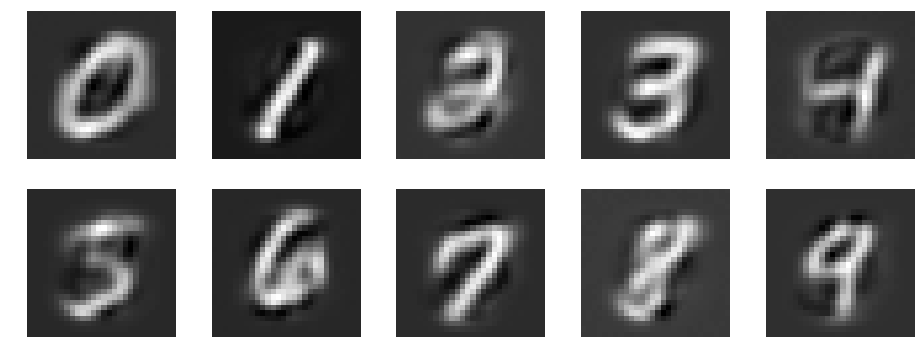

In [249]:
vecs = w1.eval()
recon = Xp[ex_ix].dot(vecs[:, :30]).dot(vecs[:, :30].T) + X.mean(0)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Sample Reconstructions of noisy images ($\sigma=0.2$) (30 PC vectors, L1 error)

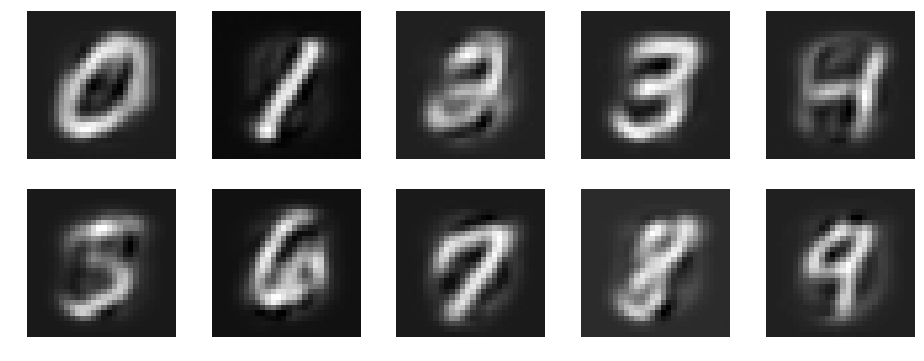

In [254]:
recon = (Xp[ex_ix]+np.random.rand(*Xp[ex_ix].shape) * 0.2).dot(vecs[:, :30]).dot(vecs[:, :30].T) + X.mean(0)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon[i].reshape(int(np.sqrt(X.shape[1])), -1))
    ax.axis('off')

## Multilayer Autoencoder

In [210]:
emb_dim = 10
g = tf.Graph()
with g.as_default():
    x_in = tf.placeholder(tf.float32, (None, 784), 'input')
    emb_space_in = tf.placeholder(tf.float32, (None, emb_dim), 'latent_input')
    w1 = tf.Variable(tf.initializers.orthogonal()((784, 128)))
    w2 = tf.Variable(tf.initializers.orthogonal()((128, emb_dim)))
    spec_emb = tf.nn.relu(tf.nn.relu(emb_space_in @ tf.transpose(w2)) @ tf.transpose(w1))
    embedded_space = tf.nn.relu(tf.nn.relu(x_in @ w1) @ w2)
    ae_recons = tf.nn.relu(tf.nn.relu((embedded_space) @ tf.transpose(w2)) @ tf.transpose(w1))
    recon_loss = tf.reduce_mean((ae_recons - x_in)**2)
    train_op = tf.train.AdamOptimizer().minimize(recon_loss)
try: 
    while True: tf.get_default_session().close()
except: pass
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

In [212]:
train_errs = []
for it in range(3000):
    _, errrr = sess.run([train_op, recon_loss], feed_dict={x_in: next_batch(256)})
    train_errs.append(errrr)
    if it%400==0: print(it)

0
400
800
1200
1600
2000
2400
2800


## Autoencoder Reconstructions

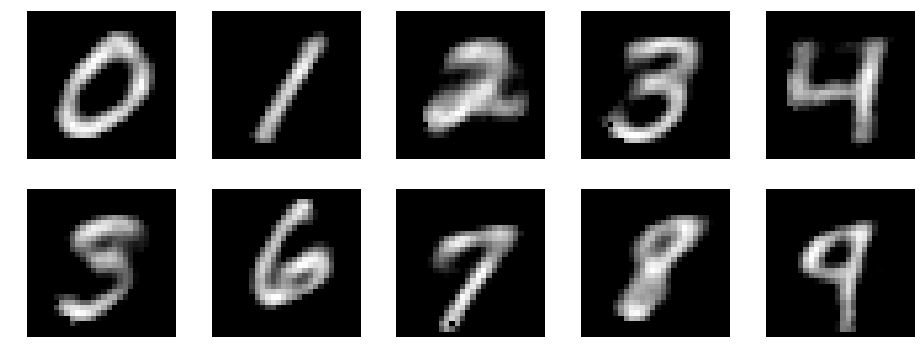

In [213]:
orig_ex = X[ex_ix]
recon_ex = sess.run(ae_recons, feed_dict={x_in:orig_ex}).reshape(-1, 28, 28)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon_ex[i])
    ax.axis('off')

## Noisy Autoencoder Reconstructions ($\sigma=0.2$)

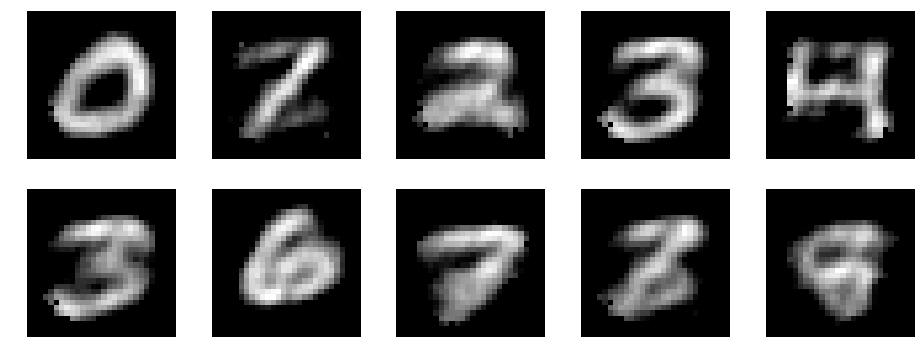

In [214]:
orig_ex = X[ex_ix]
orig_ex += np.random.rand(*orig_ex.shape) * 0.2
recon_ex = sess.run(ae_recons, feed_dict={x_in:orig_ex}).reshape(-1, 28, 28)
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(recon_ex[i])
    ax.axis('off')

In [215]:
ae_emb_x = np.vstack([sess.run(embedded_space, feed_dict={x_in:X[2048*i: (i+1)*2048]}) for i in range(len(X)//2048+1)])
kmm_ae = KMeans(n_clusters=10,)
_ = kmm_ae.fit(ae_emb_x)
kmm_recon_ae = sess.run(spec_emb, feed_dict={emb_space_in: kmm_ae.cluster_centers_}).reshape(-1, 28, 28)

## Autoencoder reconstructions from K-means in embedded space

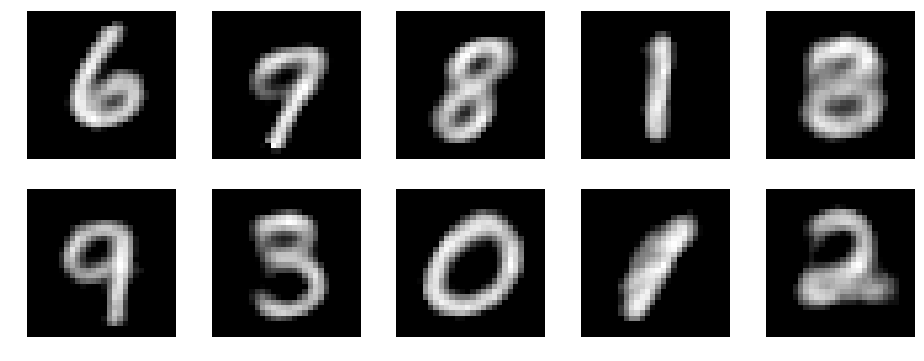

In [216]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(kmm_recon_ae[i])
    ax.axis('off')

## A generative approach
We can see here that our attempts at generating digits without some initial reference seem to fall short. Although k-means clustering in the embedded space seems to produce reasonable digits, there is no way to control which digits are discovered. We can imagine that it would be nice to be able to sample from the distribution of digits, or even better, specify the digit we wish to find, and then be able to sample plausible versions of it. To do this, we can have several functions. First, we want a function to be able to, given some noise $z$ and latent codes $c$, generate a plausible image. Then, we want another function to predict the probability of some code $c$ given some values generated by the generator function. Finally, we have a function that predicts whether or not an image is fake (the discrimator). This system can be thought of as having one function trying to generate perfect examples of digits, and another trying to determine if that generated example is real or fake. The additional function to predict the probability of $c$ is only used to attempt to tie the value of $c$ to the output. Although this is not a basis representation, the discriminator will output a good, dense, encoding of the values input to it.

We can see that the images generated by this model are b

In [255]:
import infogan

In [256]:
z_dim = 20
g, Z_in, X_in, c_in, g_sample, d_loss, g_loss, d_step, g_step, q_step = infogan.get_graph(z_dim)

In [257]:
try:
    while True:
        tf.get_default_session().close()
except: pass
sess = tf.InteractiveSession(graph=g)
sess.run(tf.global_variables_initializer())

In [258]:
save_every=1000
N1 = 4
bs = 32
np.random.seed(10091883)
ref_c = infogan.sample_c(N1**2)
ref_z = infogan.sample_z(N1**2, z_dim)
for iteration in range(30000):
    if iteration % save_every == 0:
        ims = sess.run(g_sample, feed_dict={Z_in: ref_z, c_in: ref_c}).reshape(-1, 28, 28)
        fig = plt.figure(figsize=(16, 16))
        for i in range(N1*N1):
            ax = fig.add_subplot(N1, N1, i+1)
            ax.imshow(ims[i])
            ax.axis('off')
        fig.savefig('/Users/nikil/Downloads/out/%d.png'%(iteration//save_every))
        plt.close()
    xb = next_batch(bs) 
    z_ = infogan.sample_z(bs, z_dim)
    c_ = infogan.sample_c(bs)
    _, dl = sess.run([d_step, d_loss], feed_dict={X_in: xb, Z_in: z_, c_in: c_})
    _, gl = sess.run([g_step, g_loss], feed_dict={Z_in: z_, c_in: c_})

    sess.run([q_step], feed_dict={Z_in: z_, c_in: c_})
    if iteration % 2000 == 0:
        print(f'Iter {iteration}, Discriminator loss: {dl:.5f}, Generator loss: {gl:.5f}')

Iter 0, Discriminator loss: 1.56681, Generator loss: 1.58541
Iter 2000, Discriminator loss: 0.97571, Generator loss: 1.52960
Iter 4000, Discriminator loss: 1.26885, Generator loss: 1.34058
Iter 6000, Discriminator loss: 0.80604, Generator loss: 1.74788
Iter 8000, Discriminator loss: 1.08708, Generator loss: 1.97577
Iter 10000, Discriminator loss: 1.08237, Generator loss: 1.57377
Iter 12000, Discriminator loss: 1.05756, Generator loss: 1.30031
Iter 14000, Discriminator loss: 0.99224, Generator loss: 1.48191
Iter 16000, Discriminator loss: 0.90562, Generator loss: 1.54800
Iter 18000, Discriminator loss: 0.76621, Generator loss: 1.50083
Iter 20000, Discriminator loss: 1.04160, Generator loss: 1.59385
Iter 22000, Discriminator loss: 0.73777, Generator loss: 1.63507
Iter 24000, Discriminator loss: 1.14580, Generator loss: 1.46097
Iter 26000, Discriminator loss: 0.95666, Generator loss: 1.34395
Iter 28000, Discriminator loss: 1.00169, Generator loss: 1.15503


### Samples from generative model

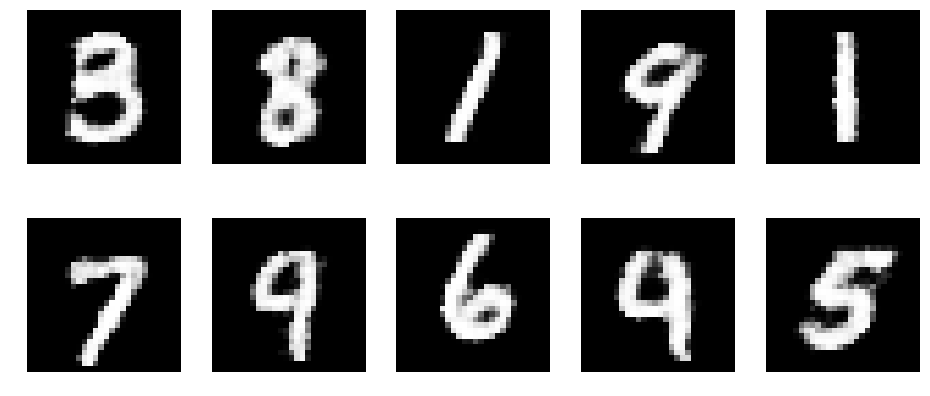

In [259]:
N1 = 4
plt.figure(figsize=(16, 7))
z_ = np.zeros((10, z_dim)) * infogan.sample_z(10, z_dim)
c_ = np.eye(10)
ims = sess.run(g_sample, feed_dict={Z_in: z_, c_in: c_}).reshape(-1, 28, 28)
for i in range(len(z_)):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(ims[i])
    ax.axis('off')

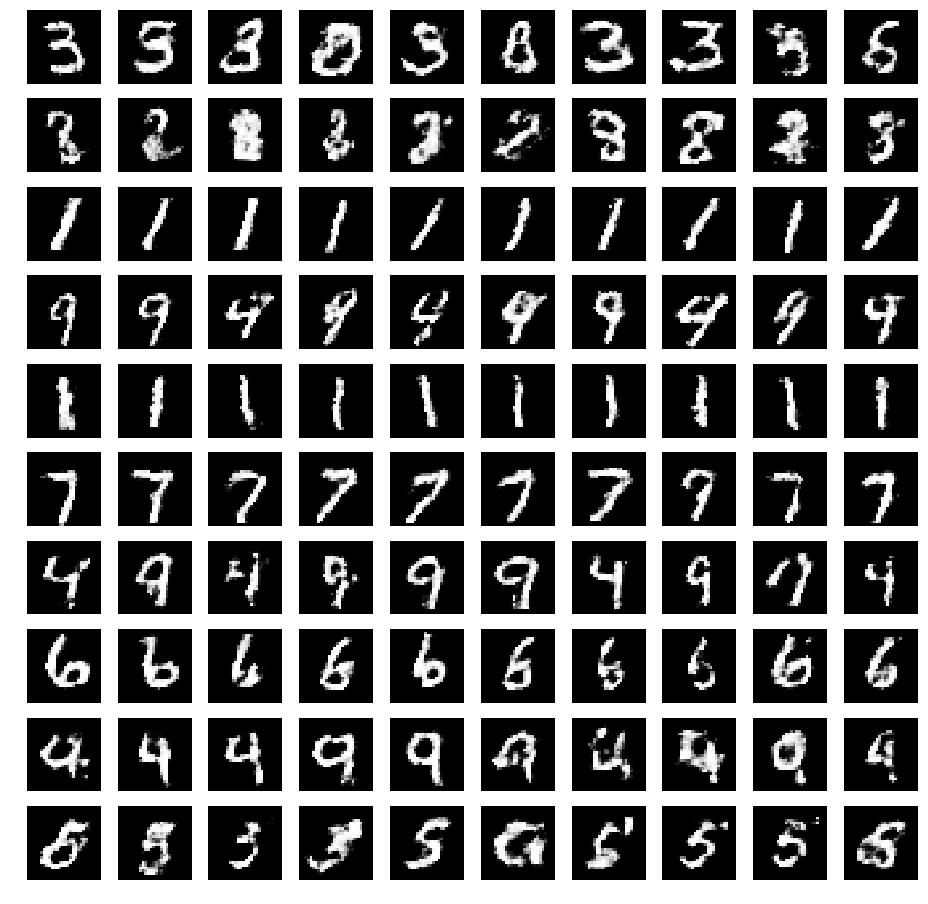

In [266]:
N1 = 4
plt.figure(figsize=(16, 16))
z_ = np.zeros((100, z_dim)) + infogan.sample_z(100, z_dim)
c_ = np.repeat(np.eye(10), 10, axis=0)
ims = sess.run(g_sample, feed_dict={Z_in: z_, c_in: c_}).reshape(-1, 28, 28)
for i in range(100):
    ax = plt.subplot(10, 10, i+1)
    ax.imshow(ims[i])
    ax.axis('off')